# PyTorch Tutorial

Based on: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

First, we need to install pytroch. For macOS with pip use in your terminal, after activating a virtual environment (and selecting the correct kernel in your jupyter notebook): 
```
pip3 install torch torchvision torchaudio 
pip3 install torchviz 
pip3 install torchsummary 
```
The latter two are just used for visualization of the neural network's architecture. Then we can go forward with the imports.

In [2]:
import torch
from torch import nn 
from torch.utils.data import DataLoader 
from torchvision import datasets 
from torchvision.transforms import ToTensor

Let us fetch some datasets for training and testing using a dataset from torchvision. 

In [3]:
# get training data 
training_data = datasets.FashionMNIST(
    root="data",
    train=True, 
    download=True,
    transform=ToTensor(),
)

# get test data 
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

1.9%

100.0%


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


100.0%


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




13.3%

100.0%
100.0%


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
batch_size = 64 # number of training examples utilised in one iteration in which we tune the gradient of the loss w.r.t. the weights

# create dataloader to wrap iterator around datasets 

train_dataloader = DataLoader(training_data, batch_size = batch_size)
test_dataloader = DataLoader(test_data, batch_size = batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H , W]: {X.shape}") # batch size, color channels (1 grey, 3 colored), height, width
    print(f"Shape/type of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H , W]: torch.Size([64, 1, 28, 28])
Shape/type of y: torch.Size([64]) torch.int64


# Neural Network Model

- inherit from PyTorch's nn.Module


First select a device for training. On macOS, I expect it will be cpu.

In [5]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [8]:
class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # flatten input data into a 1D tensor
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # fully connected layer
            nn.ReLU(), # rectified linear unit as activiation function (f(x)=max(0,x))
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512,10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits # logistic units

model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Display the Neural Network's data flow.

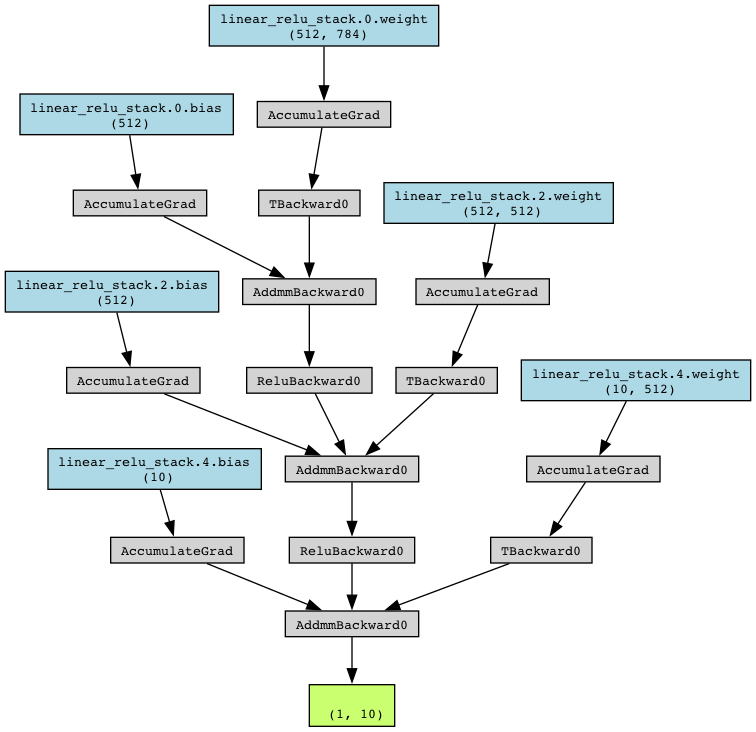

In [11]:
from torchviz import make_dot
from IPython.display import Image

# Create a random input tensor for visualization (batch_size=1, channels=1, height=28, width=28)
sample_input = torch.randn(1, 1, 28, 28)

# Forward pass to obtain the output
output = model(sample_input)

# Generate a computational graph of your model
dot = make_dot(output, params=dict(model.named_parameters()))

# Save the graph as a PDF file
dot.render("neural_network_graph")
# Save the graph as a PNG image
dot.format = 'png'
dot.render("neural_network_graph")

# Display the image in the notebook
Image("neural_network_graph.png")

In [37]:
from torchsummary import summary
# Display the architecture summary
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


Now let us train the model. Therefore, we need a loss function and an optimizer. 

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [17]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        # backprop

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch+1)*len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]") 

In [18]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches 
    correct /= size 
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



We train the model in epochs, wich are number of iterations over the dataset (in batches). For increasing number of epochs, we expect the loss to decrease and the accuracy to increase.

In [19]:
epochs = 5 # number of iterations over dataset 

for t in range(epochs):
    print(f"Epoch {t+1}\n----------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("done!")


Epoch 1
----------------
loss: 2.307618 [   64/60000]
loss: 2.295429 [ 6464/60000]
loss: 2.278785 [12864/60000]
loss: 2.268699 [19264/60000]
loss: 2.246677 [25664/60000]
loss: 2.222615 [32064/60000]
loss: 2.226878 [38464/60000]
loss: 2.198995 [44864/60000]
loss: 2.200258 [51264/60000]
loss: 2.160140 [57664/60000]
Test Error: 
 Accuracy: 49.8%, Avg loss: 2.158733 

Epoch 2
----------------
loss: 2.171214 [   64/60000]
loss: 2.159197 [ 6464/60000]
loss: 2.108603 [12864/60000]
loss: 2.124275 [19264/60000]
loss: 2.062217 [25664/60000]
loss: 2.010683 [32064/60000]
loss: 2.037487 [38464/60000]
loss: 1.963622 [44864/60000]
loss: 1.978323 [51264/60000]
loss: 1.899143 [57664/60000]
Test Error: 
 Accuracy: 53.0%, Avg loss: 1.900214 

Epoch 3
----------------
loss: 1.932613 [   64/60000]
loss: 1.900945 [ 6464/60000]
loss: 1.796575 [12864/60000]
loss: 1.835718 [19264/60000]
loss: 1.706871 [25664/60000]
loss: 1.671150 [32064/60000]
loss: 1.693835 [38464/60000]
loss: 1.601914 [44864/60000]
loss: 1.6

In [20]:
# now save the model 
filename =  "model.pth"
torch.save(model.state_dict(),filename)
print(f"Saved PyTorch Model state to {filename}")

Saved PyTorch Model state to model.pth


In [21]:
# now reload model 
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load(filename))

<All keys matched successfully>

In [33]:
# now use the loaded model to make predictions
import random

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
idx = random.choice(range(len(test_dataloader.dataset)))
x,y = test_data[idx][0], test_data[idx][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


Predicted: "Bag", Actual: "Bag"
